<a href="https://colab.research.google.com/github/herjh0405/Coding_Test/blob/master/LH_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DACON 한국토지주택공사
구내식당 식수 인원 예측 AI 경진대회

## 환경 설정

### 필요 Model Install

In [ ]:
!pip install pycaret
!pip install konlpy

### Google Drive Mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### Import Library

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
np.random.seed(0)

from pycaret.regression import *
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, log_loss

from tqdm.notebook import tqdm
from konlpy.tag import Kkma

import torch
import os, re

# # 한글 폰트 사용
# !pip install matplotlib -U

# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

# import matplotlib.pyplot as plt

# plt.rcParams['font.family']=['NanumGothic', 'sans-serif']
# plt.rcParams['axes.unicode_minus'] = False
# %matplotlib inline

In [ ]:
# 한글 폰트 사용
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import os

def change_matplotlib_font(font_download_url):
    FONT_PATH = 'MY_FONT'
    
    font_download_cmd = f"wget {font_download_url} -O {FONT_PATH}.zip"
    unzip_cmd = f"unzip -o {FONT_PATH}.zip -d {FONT_PATH}"
    os.system(font_download_cmd)
    os.system(unzip_cmd)
    
    font_files = fm.findSystemFonts(fontpaths=FONT_PATH)
    for font_file in font_files:
        fm.fontManager.addfont(font_file)

    font_name = fm.FontProperties(fname=font_files[0]).get_name()
    matplotlib.rc('font', family=font_name)
    print("font family: ", plt.rcParams['font.family'])

font_download_url = "https://fonts.google.com/download?family=Noto%20Sans%20KR"
change_matplotlib_font(font_download_url)

## Data Preprocessing

### Load Data

In [ ]:
path = '/content/drive/MyDrive/구내식당/water/'
train = pd.read_csv(path+'train.csv')
test = pd.read_csv(path+'test.csv')
holiday = pd.read_csv(path+'holidays.csv', index_col=0)
corona = pd.read_csv(path+'corona_data.csv')

df = pd.concat([train.iloc[:, :-2], test])
target_df = train.iloc[:, -2:]
df.columns = ['일자', '요일', '정원','휴가자', '출장자', '야근자',\
                 '재택근무자', '조식', '중식', '석식']

### 년, 월, 일 컬럼 생성

In [ ]:
df['재택근무자'] = df['재택근무자'].astype('int')

df['일자'] = pd.to_datetime(df['일자'])
df['년'] = df['일자'].dt.year
df['월'] = df['일자'].dt.month
df['일'] = df['일자'].dt.day
df['월일'] = df['일자'].apply(lambda x : str(x)[5:10])

### 공휴일 데이터 추가
* Only_공휴일 전후 컬럼
* 공휴일+휴일 전후 컬럼 추가

In [ ]:
holiday['date'] = pd.to_datetime(holiday['date'])

df['only_before_holiday'] = df['일자'].apply(lambda x : 1 if (x+dt.timedelta(1) in holiday['date'].tolist()) else 0)
df['only_after_holiday'] = df['일자'].apply(lambda x : 1 if (x-dt.timedelta(1) in holiday['date'].tolist()) else 0)

df['before_holiday'] = df['일자'].apply(lambda x : 1 if (x+dt.timedelta(1) in holiday['date'].tolist())\
                                      or ((x+dt.timedelta(1)).weekday() == 5) or ((x+dt.timedelta(1)).weekday() == 6) else 0)
df['after_holiday'] = df['일자'].apply(lambda x : 1 if (x-dt.timedelta(1) in holiday['date'].tolist())\
                                     or ((x-dt.timedelta(1)).weekday() == 5) or ((x-dt.timedelta(1)).weekday() == 6) else 0)

train = pd.concat([df.iloc[:train.shape[0],:], target_df], axis=1)

## 데이터 시각화
* 시간에 따른 time_col의 변화를 관찰
    * time_col : `'정원', '휴가자', '출장자', '야근자', '재택근무자', '중식계', '석식계'`

* 삼성 SDS에서 실시한 적이 있는 대회라고 함
    * RNN에서 휴가와 날씨에 가중치를 둬서 좋은 결과를 냈다고 함 -> 참고하면 좋을 듯
    * 일기예보 데이터를 사용해보는 건 어떨까?

<br>

### 가설 1. 재택근무는 코로나 때문에 생겼을 것이다.
* 코로나 이전과 이후로, 식수 인원이 큰 차이가 있을 것이다

<br>

### 가설 2. 날씨가 큰 영향을 미칠것이다
* 월별, 계절별 데이터가 차이날 것


<br>

### 궁금증 1. 조식이 과연 의미가 있을까?
* 일단 없을거라 생각되지만 확인하기 어려움
    * 조식 아침 8시 제공
    * 하루 본사 2명 숙직 18-익일09시
    * 점심 1140-1300, 저녁 1800-
        * 1140-1210 정도로 생각하라고 함


In [ ]:
time_col = ['정원', '휴가자', '출장자', '야근자', '재택근무자', '중식계', '석식계']

In [ ]:
plt.figure(figsize=(10, 8))
for col in time_col : 
    plt.plot(train['일자'], train[col], label=col)

plt.xlabel('날짜(일)', fontsize=10)
plt.ylabel('인원 수', fontsize=10)
plt.title('날짜 별 인원 수', fontsize=15)
plt.legend('best', labels=time_col)
plt.show()

In [ ]:
df['요일'] = df['일자'].dt.weekday
df['야근_가능'] = df['요일'].apply(lambda x : 1 if (x==2) or (x==4) else 0)
df['출근인원'] = df['정원']-(df['휴가자']+df['출장자']+df['재택근무자'])
df['휴가비율'] = df['휴가자']/df['정원']
df['출장비율'] = df['출장자']/df['정원']
df['야근비율'] = df['야근자']/df['출근인원']
df['재택비율'] = df['재택근무자']/df['정원']

In [ ]:
train = pd.concat([df.iloc[:train.shape[0], :], target_df], axis=1)
test = df.iloc[train.shape[0]:, :]

In [ ]:
train_1 = train[['일자', '요일', '월', '년', '휴가비율', '출장비율', '중식계']]
train_2 = train[['일자', '요일', '월', '년', '야근_가능', '휴가비율', '출장비율', '야근비율', '석식계']]

In [ ]:
def feature_pipeline(df) : 
    df['요일'] = df['일자'].dt.weekday
    df['야근_가능'] = df['요일'].apply(lambda x : 1 if (x==2) or (x==4) else 0)
    df['출근인원'] = df['정원']-(df['휴가자']+df['출장자']+df['재택근무자'])
    df['휴가비율'] = df['휴가자']/df['정원']
    df['출장비율'] = df['출장자']/df['정원']
    df['야근비율'] = df['야근자']/df['출근인원']
    df['재택비율'] = df['재택근무자']/df['정원']

    X_pivot_train = pd.pivot_table(data = df,
                values = ['정원', '휴가자', '출장자', '야근자', '재택근무자'],
                index = '요일',
                aggfunc = ['mean', 'min', 'max',
                            'std', 'var']
                )
    X_columns = [agg + '_' + '요일' + '_' + column for agg, column in X_pivot_train.columns]
    X_pivot_train.columns = X_columns
    df = pd.merge(df, X_pivot_train, on ='요일')

    X_pivot_train = pd.pivot_table(data = df,
                values = ['정원', '휴가자', '출장자', '야근자', '재택근무자'],
                index = '월',
                aggfunc = ['mean', 'min', 'max',
                            'std', 'var']
                )
    X_columns = [agg + '_' + '월' + '_' + column for agg, column in X_pivot_train.columns]
    X_pivot_train.columns = X_columns
    df = pd.merge(df, X_pivot_train, on ='월')

    return df

In [ ]:
# train = feature_pipeline(train)
# test = feature_pipeline(test)

In [ ]:
# train.drop(['조식', '월일', '일', '년'], inplace=True, axis=1)
# test.drop(['조식', '일', '년'], inplace=True, axis=1)

In [ ]:
# train_1 = train.drop(['석식계'], axis=1)
# train_2 = train.drop(['중식계'], axis=1)

In [ ]:
reg = setup(data=train_1,
            target='중식계',
            numeric_imputation = 'mean',
            normalize = True,
            silent= True)

In [ ]:
compare_models()

In [ ]:
best_5 = compare_models(sort='MAE', n_select=5)

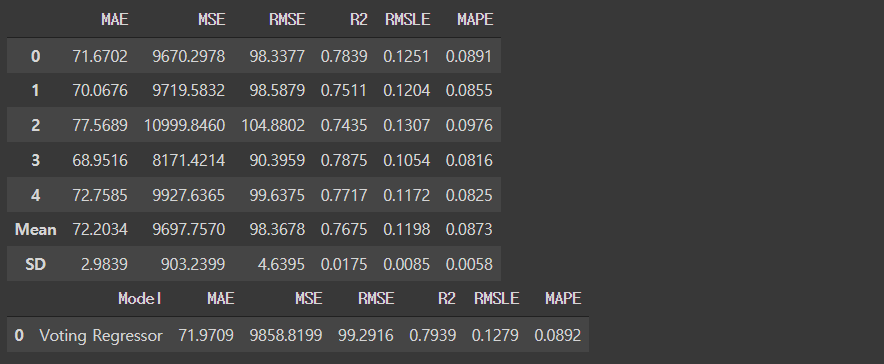

In [ ]:
blended = blend_models(estimator_list= best_5, fold=5, optimize='MAE')
pred_holdout = predict_model(blended)
final_model = finalize_model(blended)
pred1 = predict_model(final_model, test)

In [ ]:
sample_submission = pd.read_csv(path+'sample_submission.csv')

In [ ]:
submission = sample_submission.copy()

In [ ]:
submission['중식계'] = pred1['Label']

In [ ]:
reg = setup(data=train_2,
            target='석식계',
            numeric_imputation = 'mean',
            normalize = True,
            silent= True)

In [ ]:
compare_models()

In [ ]:
best_5 = compare_models(sort = 'MAE', n_select = 5)

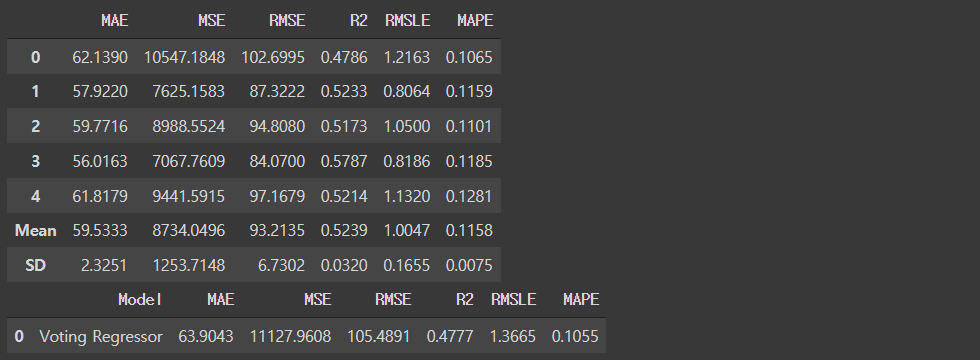

In [ ]:
blended = blend_models(estimator_list = best_5, fold = 5, optimize = 'MAE')
pred_holdout = predict_model(blended)
final_model = finalize_model(blended)
pred2 = predict_model(final_model, test)

In [ ]:
submission['석식계'] = pred2['Label']

In [ ]:
submission

In [ ]:
submission.to_csv('./20210608_02_holiday.csv', index=False)

In [ ]:
# 나중에 한번 써보자
# train['일자'].dt.week